# Loading the required packages

In [1]:
import numpy as np, pandas as pd, xgboost as xgb, matplotlib.pyplot as pl, pickle, shap,matplotlib, altair as alt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import plot_tree
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
# print the JS visualisation code to the notebook
shap.initjs()
# enabling the vega object rendering used by altair
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

# Loading the data

In [2]:
from sklearn.datasets import load_boston
boston = load_boston()
print(boston.data.shape)

(506, 13)


# Data Analysis: check metadata

In [ ]:
print(boston.DESCR)

# Convert the dataset to a Pandas dataframe

In [3]:
Boston = pd.DataFrame(boston.data,columns=boston.feature_names)
# Note how we add the target variable median house value to the pandas dataframe
Boston['MEDV'] = boston.target
Boston.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


# Create test and training set

In [4]:
x = Boston.loc[:, Boston.columns !='MEDV'].values
y = Boston.loc[:, Boston.columns =='MEDV'].values

In [5]:
x_train, x_test, y_train, y_test = train_test_split (Boston[boston.feature_names],y, test_size = 0.25, random_state=34)

# Baseline model: OLS Linear regression

In [ ]:
lin_reg = LinearRegression().fit(x_train, y_train)
r_sq = lin_reg.score(x_train,y_train)
r_sq_t = lin_reg.score(x_test,y_test)
y_pred = lin_reg.predict(x_test)
print('Coefficient of determination: Training Set',r_sq)
print('Coefficient of determination: Test Set',r_sq_t)
print('Root Mean Squared Error of baseline model on test set:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [ ]:
pickle.dump(lin_reg, open("lin_reg.dat", "wb"))

In [ ]:
print(f'Since the linear model has an r-squared of {r_sq_t} on the test set, we will continue with a linear kernel')

# XGBOOST - preperation. Create DMatrices

In [6]:
dtrain = xgb.DMatrix(x_train, label=y_train, feature_names=boston.feature_names)
dtest  = xgb.DMatrix(x_test, label=y_test, feature_names=boston.feature_names)

# Setting up the parameters for XGBOOST

In [ ]:
params = {
    #note that these paramaters will be tuned using Grid Search
    'max_depth': 10,
    'min_child_weight': 1,
    'eta': .3,
    'subsample': 1,
    'colsample_bytree': 1,
    # other parameters
    'objective':'reg:squarederror',
    'eval_metric':'rmse'
}

In [ ]:
num_boost_round = 999

In [ ]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round = num_boost_round,
    evals = [(dtest, "Test")],
    early_stopping_rounds = 10
)

 A simple XGBOOST model already outperforms the baseline model. Let's try to improve it using cross-validated 
Grid Search 

In [ ]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round = num_boost_round,
    seed = 34,
    nfold = 10,
    metrics = {'rmse'},
    early_stopping_rounds = 10
)
best_cv_result = cv_results['test-rmse-mean'].min()
print(cv_results)
print(f'the best cross-validated rmse using the non optimized parameters is: {best_cv_result}')

# Use grid search to find the optimized parameters for XGBOOST on the Boston Housing dataset

In [ ]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range (11)
    for min_child_weight in range (11)
]

In [ ]:
# Define intitial best params and RMSE
min_rmse = float('inf')
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print('CV with max_depth{}, min_child_weight{}'.format(
        max_depth,
        min_child_weight))
    # Update the parameters:
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV 
    cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round = num_boost_round,
    seed = 34,
    nfold = 10,
    metrics = {'rmse'},
    early_stopping_rounds = 10
    )
    # update best RMSE
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].idxmin()
    print('\tRMSE{} for {} rounds'.format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth, min_child_weight)
print('Best params: {}, {}, RMSE: {}'.format(best_params[0], best_params[1], min_rmse))

 update the params with the optimal ones from the Grid Search above:

In [ ]:
params['max_depth'] = 4
params['min_child_weight'] = 3

And continue with the next set of parameters

In [ ]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range (11)]
    for colsample in [i/10. for i in range (11)]
]

In [ ]:
# Define intitial best params and RMSE
min_rmse = float('inf')
best_params = None
for subsample, colsample in reversed (gridsearch_params):
    print('CV with subsample{}, colsample{}'.format(
        subsample,
        colsample))
    # Update the parameters:
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV 
    cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round = num_boost_round,
    seed = 34,
    nfold = 10,
    metrics = {'rmse'},
    early_stopping_rounds = 10
    )
    # update best RMSE
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].idxmin()
    print('\tRMSE{} for {} rounds'.format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample, colsample)
print('Best params: {}, {}, RMSE: {}'.format(best_params[0], best_params[1], min_rmse))

update the params with the optimal ones from the Grid Search above:

In [ ]:
params['subsample'] = 1
params['colsample_bytree'] = 1

In [ ]:
gridsearch_params = [
    (eta)
    for eta in np.arange(.0001,3,.01)
]

In [ ]:
# Define intitial best params and RMSE
min_rmse = float('inf')
best_params = None
for eta in gridsearch_params:
    print('CV with eta={}'.format(eta))
    # Update the parameters:
    params['eta'] = eta
    # Run CV 
    cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round = num_boost_round,
    seed = 34,
    nfold = 10,
    metrics = {'rmse'},
    early_stopping_rounds = 10
    )
    # update best RMSE
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].idxmin()
    print('\tRMSE{} for {} rounds'.format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta 
print('Best params: {}, RMSE: {}'.format(best_params, min_rmse))

update the params with the optimal ones from the Grid Search above:

In [ ]:
params['eta'] = 0.1701

In [ ]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round = num_boost_round,
    evals = [(dtest, "Test")],
    early_stopping_rounds = 10
)

In [ ]:
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round = num_boost_round,
    evals = [(dtest,"Test")]
)

## Save/load the optimised model (original API):

In [ ]:
# With this version of xgboost, feature names are lost. Therefore the Pickle API is used.
best_model.save_model("xgboost_cross_validated")
loaded_model = xgb.Booster()
loaded_model.load_model("xgboost_cross_validated")

## Save the optimised model (Pickle API):

In [ ]:
pickle.dump(best_model, open("xgboost_cv_best_pickle.dat", "wb"))

## Load the optimised model:

In [7]:
loaded_model = pickle.load(open("xgboost_cv_best_pickle.dat", "rb"))

## Visualize the results

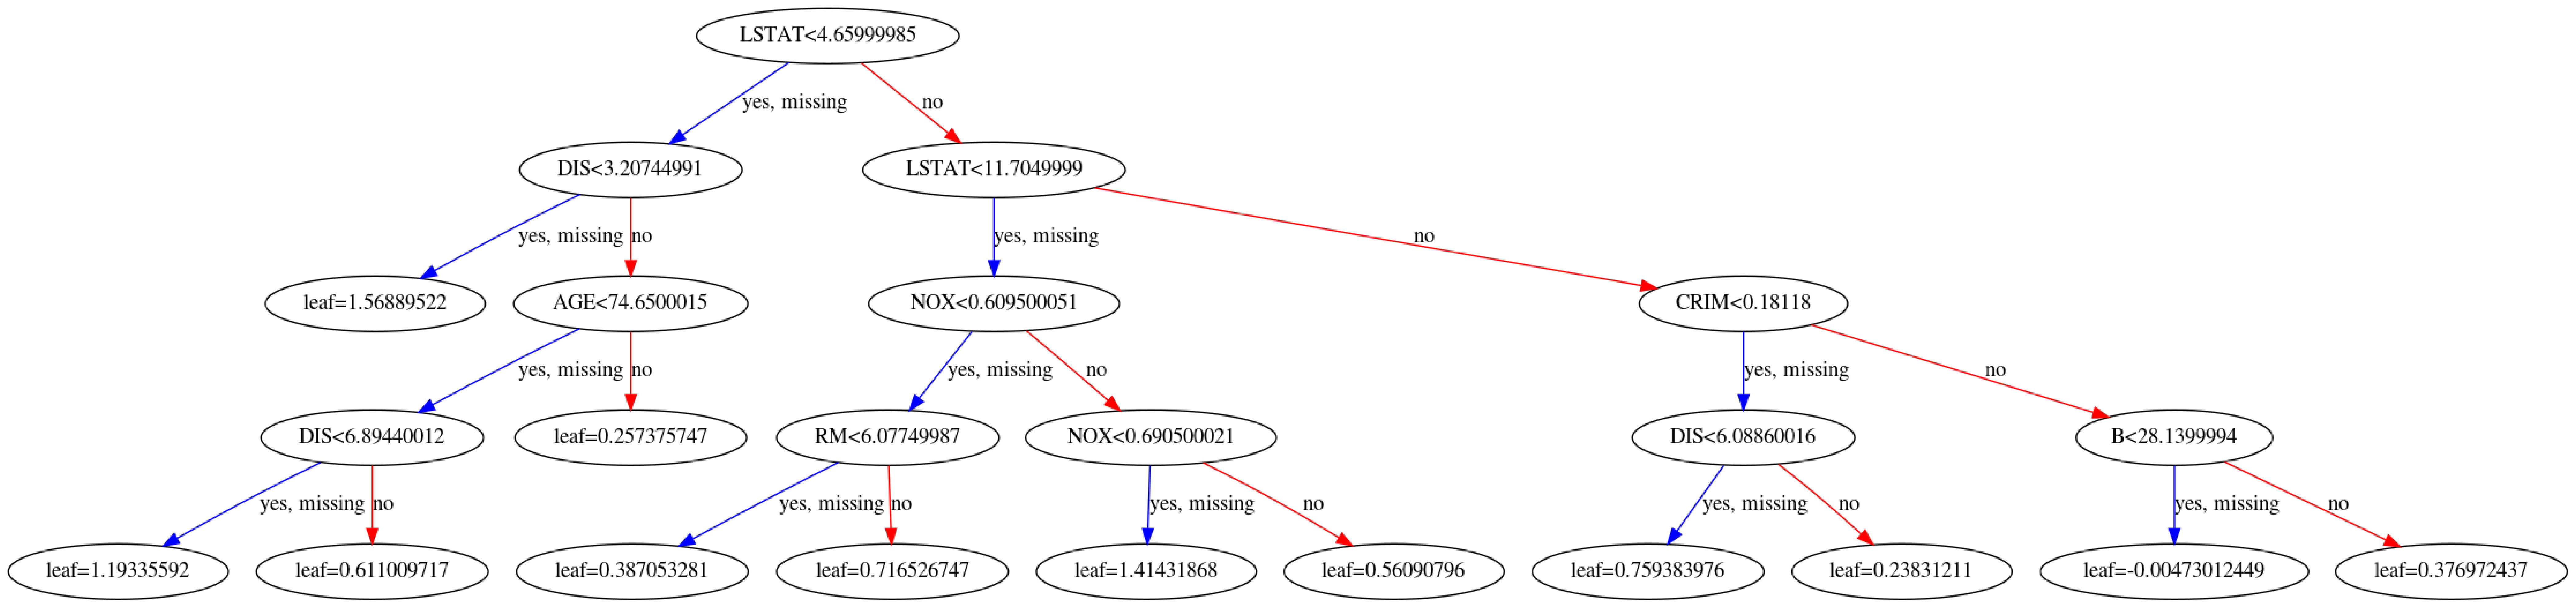

In [8]:
plot_tree(loaded_model,num_trees = 10)
fig = pl.gcf()
fig.set_size_inches(150,100)
pl.show()

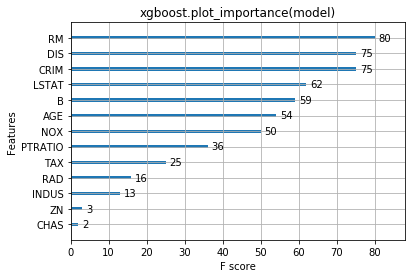

In [9]:
xgb.plot_importance(loaded_model)
pl.title ("xgboost.plot_importance(model)")
pl.show()

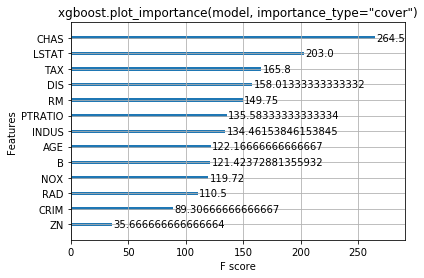

In [10]:
xgb.plot_importance(loaded_model, importance_type="cover")
pl.title ('xgboost.plot_importance(model, importance_type="cover")')
pl.show()

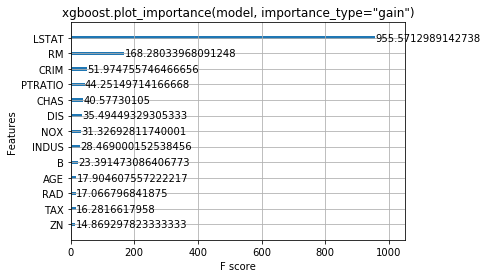

In [11]:
xgb.plot_importance(loaded_model, importance_type="gain")
pl.title ('xgboost.plot_importance(model, importance_type="gain")')
pl.show()

# Using SHAP values for consistent importance metrics and model explainations

In [12]:
explainer = shap.TreeExplainer(loaded_model)
shap_values = explainer.shap_values(x_train)

In [ ]:
pd.Series(shap_values[45,:])

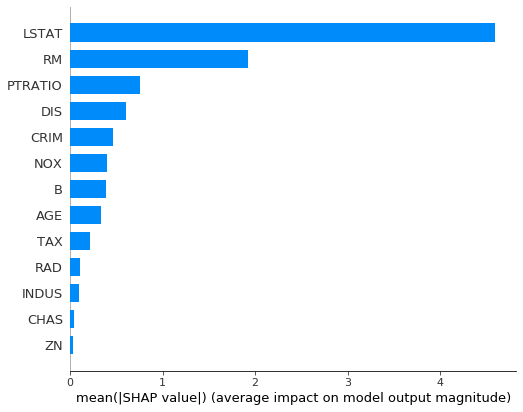

In [13]:
shap.summary_plot(shap_values,x_train,plot_type="bar")


In [ ]:
shap.force_plot(explainer.expected_value, shap_values,x_train)

In [ ]:
shap.summary_plot(shap_values,x_train)

In [ ]:
print(f'the real value of the obeservation of interest is: {y_train[1]}')

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[1,:],x_train.iloc[8,:])

In [ ]:
for name in x_train.columns:
    shap.dependence_plot(name,shap_values,x_train,display_features=x_train)

 simple supervised clustering by shape values leads to groups that are relevant for the prediction task at hand.\
 Source: https://slundberg.github.io/shap/notebooks/Census income classification with XGBoost.html

In [ ]:
shap_pca50 = PCA(n_components=13).fit_transform(shap_values)
shap_embedded = TSNE(n_components=2, perplexity=50).fit_transform(shap_values)

In [ ]:
cdict1 = {
    'red': ((0.0, 0.11764705882352941, 0.11764705882352941),
            (1.0, 0.9607843137254902, 0.9607843137254902)),

    'green': ((0.0, 0.5333333333333333, 0.5333333333333333),
              (1.0, 0.15294117647058825, 0.15294117647058825)),

    'blue': ((0.0, 0.8980392156862745, 0.8980392156862745),
             (1.0, 0.3411764705882353, 0.3411764705882353)),

    'alpha': ((0.0, 1, 1),
              (0.5, 1, 1),
              (1.0, 1, 1))
}  # #1E88E5 -> #ff0052
red_blue_solid = LinearSegmentedColormap('RedBlue', cdict1)

In [ ]:
f = pl.figure(figsize=(5,5))
pl.scatter(shap_embedded[:,0],
          shap_embedded[:,1],
           c=shap_values[:1000,:].sum(1).astype(np.float64),
           linewidth=0, alpha=1., cmap=red_blue_solid)
cb = pl.colorbar(label="Predicted Median House Value", aspect=40,orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x',length=0)
cb.ax.xaxis.set_label_position('top')
pl.gca().axis("off")
pl.show()


In [ ]:
for feature in x_train.columns:
    f = pl.figure(figsize=(5,5))
    pl.scatter(shap_embedded[:,0],
               shap_embedded[:,1],
               c=x_train[feature].values[:1000].astype(np.float64),
               linewidth=0, alpha=1., cmap=red_blue_solid)
    cb = pl.colorbar(label=feature, aspect=40, orientation="horizontal")
    cb.set_alpha(1)
    cb.draw_all()
    cb.outline.set_linewidth(0)
    cb.ax.tick_params('x', length=0)
    cb.ax.xaxis.set_label_position('top')
    pl.gca().axis("off")
    pl.show()

Train a model with only two leaves per tree and hence no interaction terms between features

In [ ]:
# Set the optimal paramters, we've found earlier using cross validation on Grid Search.
params = {
    'max_depth': 1,
    'eta': .05,
    'subsample': 0.5,
    # other parameters 
    'objective':'reg:squarederror',
    'eval_metric':'rmse'
}
num_boost_round = loaded_model.best_iteration+1
no_interactions_model = xgb.train(
    params,
    dtrain,
    num_boost_round = num_boost_round,
    evals = [(dtest, "test")],
    verbose_eval=100)

In [ ]:
shap_values_no_interactions = shap.TreeExplainer(no_interactions_model).shap_values(x_train)

In [ ]:
for name in x_train.columns:
    shap.dependence_plot(name,shap_values_no_interactions,x_train)

Selection Histogram

In [ ]:
x_train.insert(13, "LSTAT_SHAP", pd.Series(shap_values[:,12]))
x_train.insert(6, "RM_SHAP", pd.Series(shap_values[:,5]))

In [ ]:
x_train.insert(14, "MEDV", y_train)

In [ ]:
x_train.head(1)

In [ ]:
source = x_train

brush = alt.selection(type='interval')

points = alt.Chart(source).mark_point().encode(
    x='LSTAT:Q',
    y='LSTAT_SHAP:Q',
    color=alt.condition(brush, 'MEDV:Q', alt.value('lightgray'))
).add_selection(
    brush
)

bars = alt.Chart(source).mark_bar().encode(
    y='MEDV:Q',
    color='MEDV:Q',
    x='count(Origin):Q'
).transform_filter(
    brush
)

points & bars